In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [5]:
path = untar_data(URLs.CAMVID)

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [7]:
path_img = path/'images'
path_lbl = path/'labels'

In [8]:
path_lbl.ls()

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_05070_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00150_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010260_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03510_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05940_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08149_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08037_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01920_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01920_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01320_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01320_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07710_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01770_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_04410_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_0

In [14]:
get_name = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [10]:
img = open_image(path_img.ls()[0])

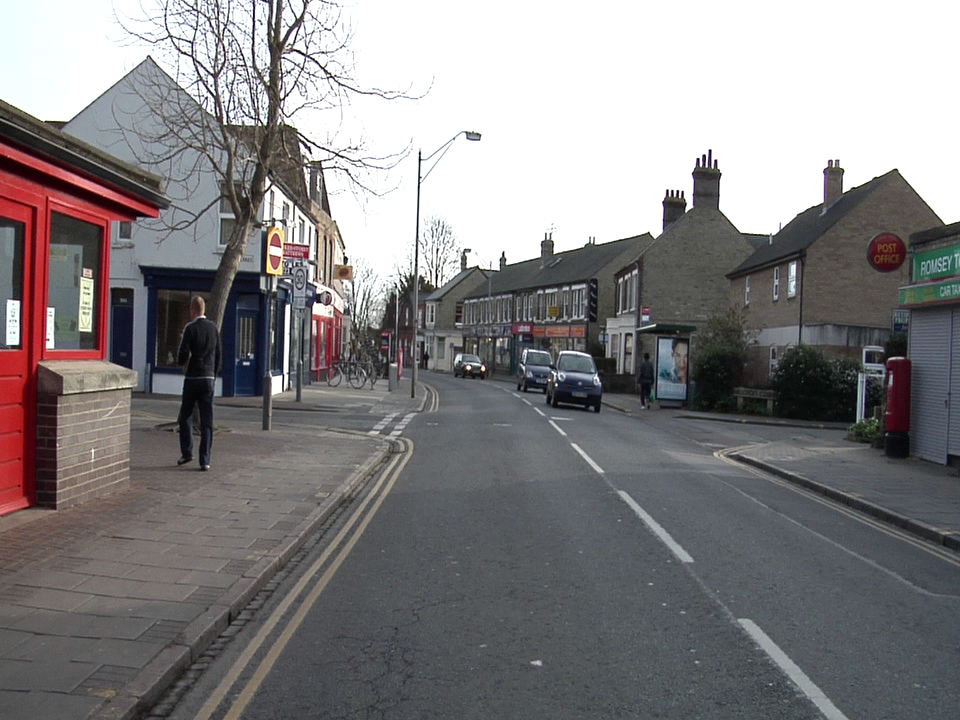

In [11]:
img

In [15]:
get_name(path_img.ls()[0])

PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04560_P.png')

In [17]:
mask = open_mask(get_name(path_img.ls()[0]))

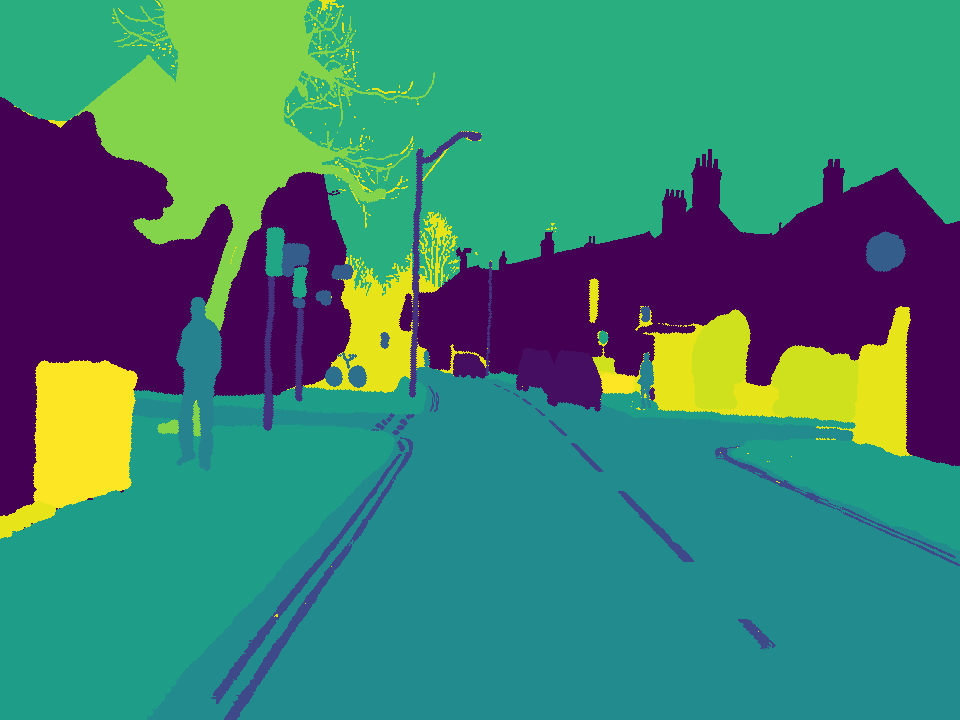

In [18]:
mask

In [20]:
codes = np.loadtxt(path/'codes.txt', dtype = str)

In [21]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [22]:
src = SegmentationItemList.from_folder(path_img).split_by_fname_file(path/'valid.txt').label_from_func(get_name, classes = codes)

In [23]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None

In [26]:
free = gpu_mem_get_free_no_cache()
bs = 4
if free > 8200:
    bs = 8
print(bs)

8


In [27]:
data = src.transform(get_transforms(), tfm_y = True, size = 128).databunch(bs = bs).normalize(imagenet_stats)

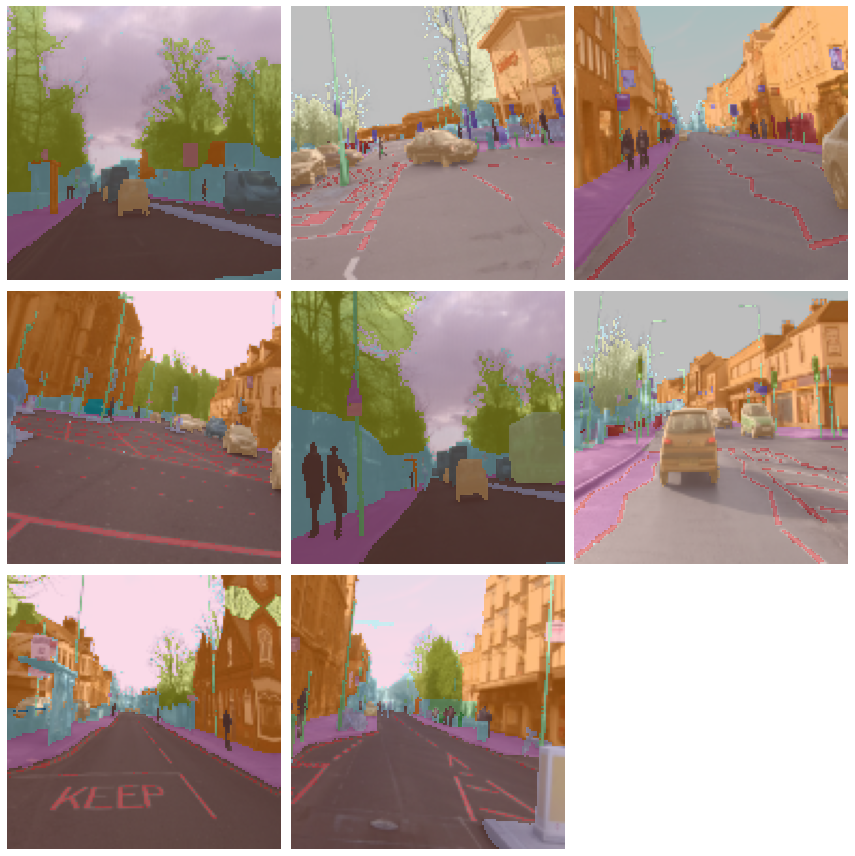

In [28]:
data.show_batch(rows = 3)

In [29]:
name_id= {}  
for i in range(len(codes)):
    name_id[str(codes[i])] = 1

In [30]:
name_id

{'Animal': 1,
 'Archway': 1,
 'Bicyclist': 1,
 'Bridge': 1,
 'Building': 1,
 'Car': 1,
 'CartLuggagePram': 1,
 'Child': 1,
 'Column_Pole': 1,
 'Fence': 1,
 'LaneMkgsDriv': 1,
 'LaneMkgsNonDriv': 1,
 'Misc_Text': 1,
 'MotorcycleScooter': 1,
 'OtherMoving': 1,
 'ParkingBlock': 1,
 'Pedestrian': 1,
 'Road': 1,
 'RoadShoulder': 1,
 'Sidewalk': 1,
 'SignSymbol': 1,
 'Sky': 1,
 'SUVPickupTruck': 1,
 'TrafficCone': 1,
 'TrafficLight': 1,
 'Train': 1,
 'Tree': 1,
 'Truck_Bus': 1,
 'Tunnel': 1,
 'VegetationMisc': 1,
 'Void': 1,
 'Wall': 1}

In [32]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != name_id['Void']
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [33]:
metrics = acc_camvid

In [34]:
learn = unet_learner(data, models.resnet50, metrics = acc_camvid, wd = 1e-02)

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


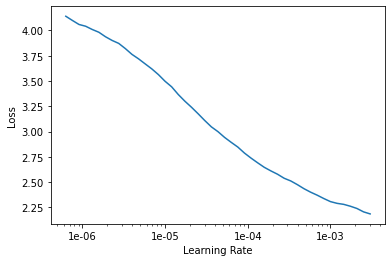

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, slice(8e-05), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.620306,1.123707,0.700588,01:05
1,1.073130,0.881706,0.747047,01:05
2,0.837969,0.681432,0.819572,01:06
3,0.735320,0.625317,0.831857,01:07
4,0.662575,0.602265,0.834334,01:08
5,0.607877,0.517456,0.849205,01:11
6,0.561709,0.508188,0.840734,01:13
7,0.532915,0.509015,0.843975,01:13
8,0.509727,0.452371,0.865917,01:13
9,0.450006,0.409253,0.877917,01:15


In [38]:
learn.save('stage-1')

In [40]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

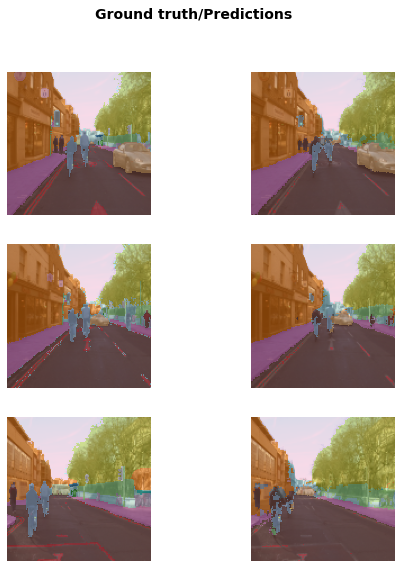

In [43]:
learn.show_results(rows = 3, figsize = (8,9))

In [44]:
learn.unfreeze()

In [45]:
lr = 8e-05

In [46]:
learn.fit_one_cycle(10, slice(lr/400, lr/4), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.398786,0.397407,0.881777,01:05
1,0.392458,0.390619,0.883854,01:06
2,0.389856,0.378274,0.887410,01:08
3,0.385841,0.378743,0.886362,01:09
4,0.383165,0.369908,0.889288,01:10
5,0.380953,0.363603,0.890045,01:16
6,0.384325,0.365433,0.887352,01:16
7,0.371587,0.340486,0.898849,01:15
8,0.362489,0.359448,0.890627,01:17
9,0.346118,0.352196,0.890964,01:15


In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


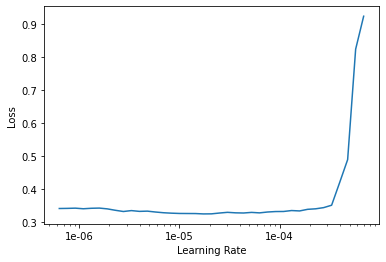

In [48]:
learn.recorder.plot()

In [49]:
lr

8e-05

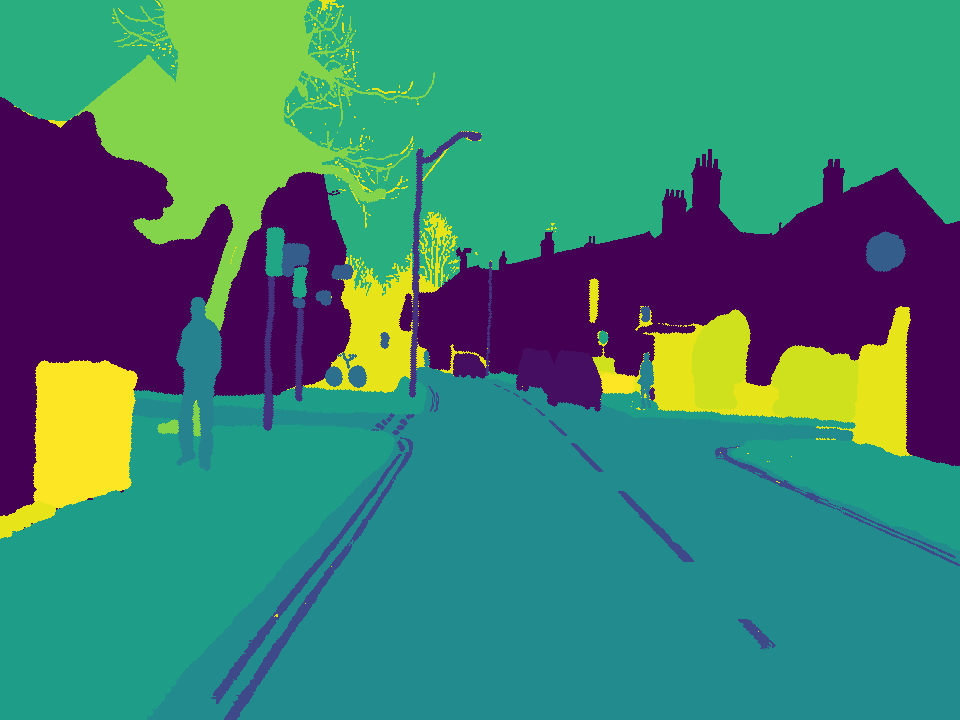

In [50]:
mask

In [54]:
src_size = mask.shape[1]

In [55]:
src_size

720

In [56]:
learn.save('stage-2')

In [57]:
learn.destroy()
free = gpu_mem_get_free_no_cache()

this Learner object self-destroyed - it still exists, but no longer usable


In [58]:
free

14275

In [59]:
    bs = 3

In [60]:
bs

3

In [62]:
data = src.transform(get_transforms(), tfm_y = True, size = src_size)

In [63]:
data = data.databunch(bs = bs)

In [64]:
data = data.normalize(imagenet_stats)

In [65]:
learn = unet_learner(data, models.resnet50, acc_camvid, wd = 1e-02)

In [66]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720)
y: SegmentationLabelList
ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720)
y: SegmentationLabelList
ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720),ImageSegment (1, 720, 720)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [67]:
learn.lr_find()

epoch,train_loss,valid_loss,time


RuntimeError: CUDA out of memory. Tried to allocate 288.00 MiB (GPU 0; 14.73 GiB total capacity; 13.41 GiB already allocated; 255.88 MiB free; 13.69 GiB reserved in total by PyTorch)

In [ ]:
learn.recorder.plot()